### Task
* Build, train, and evaluate 2 special types of networks neural network with Pytorch.
* A CNN for a spatial prediction problem
* A RNN or LSTM for a sequential problem
* Experiment with at least 2 different variations of hyperparameters for each network.
* Optional: Use gradio to build a simple interactive demo (in the notebook).

### CNN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Mnist dataset has 70,000 data with 60,000 train data and 10,000 test data.

from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(root = 'data', train = True, transform = ToTensor(), download = True)
test_data = datasets.MNIST(root = 'data', train = False, transform = ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
# Hyper-parameters of the model(?)
num_epochs = 4
batch_size = 4
learning_rate = 0.003

In [4]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [5]:
print(train_data.data.size())
print(test_data.data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [6]:
from torch.utils.data import DataLoader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=True, num_workers=1)

In [7]:
classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

In [22]:
# implement conv net
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) #3 channels, 6 filters, 5x5 filter size
        self.pool = nn.MaxPool2d(2,2) #size 2X2, stride: 2
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120) #16*5*5= number of output channels * dimension of the output layer after feature learning; 120 manually set as outcome of the 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) #the output dimension (in our case 10) needs to be equal to the number of classes
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4) #torch.view() function freshape the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = ConvNet().to(device)

In [20]:
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss already includes SoftMax
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [23]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad() #with zero_grad() we ensure that the gradients are properly reset to zero at the start of each iteration
        loss.backward()
        optimizer.step()
        #wandb.log({"loss": loss})  uncomment this line if you want to send data to weights and biases interface


        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            # Calculate average accuracy for every 2000 steps
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                accuracy = correct / total
                #wandb.log({"accuracy": accuracy}) uncomment this line if you want to send data to weights and biases interface
        
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Finished Training


In [24]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 9.8 %
Accuracy of zero: 100.0 %
Accuracy of one: 0.0 %
Accuracy of two: 0.0 %
Accuracy of three: 0.0 %
Accuracy of four: 0.0 %
Accuracy of five: 0.0 %
Accuracy of six: 0.0 %
Accuracy of seven: 0.0 %
Accuracy of eight: 0.0 %
Accuracy of nine: 0.0 %


### Find out **Hyperparameter** !!!

We tried various parameters :
1. The number of filters (6, 16, 32)
2. Epoch, learning rate change (4/50, 0.003/0.001)
3. Optimizer (RMSprop, Adam)

Our result!!!

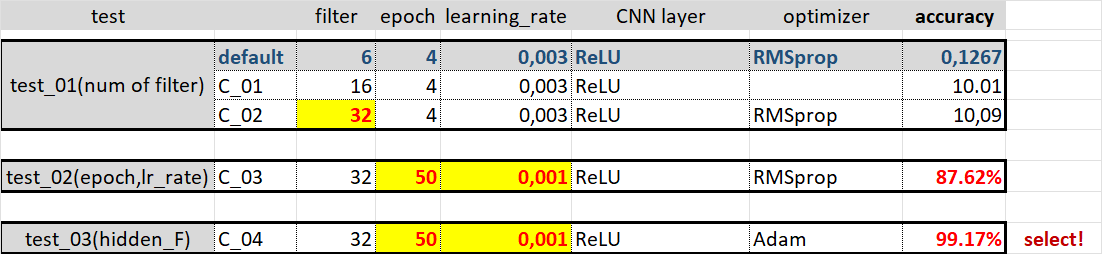

### Test_01 with different the number of filters(6, 16, 32)

In [27]:
# change the number of filters with 16
# implement conv net
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5) #3 channels, 6 filters, 5x5 filter size
        self.pool = nn.MaxPool2d(2,2) #size 2X2, stride: 2
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32*4*4, 120) #16*5*5= number of output channels * dimension of the output layer after feature learning; 120 manually set as outcome of the 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) #the output dimension (in our case 10) needs to be equal to the number of classes
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32*4*4) #torch.view() function freshape the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = ConvNet().to(device)

In [28]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad() #with zero_grad() we ensure that the gradients are properly reset to zero at the start of each iteration
        loss.backward()
        optimizer.step()
        #wandb.log({"loss": loss})  uncomment this line if you want to send data to weights and biases interface


        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            # Calculate average accuracy for every 2000 steps
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                accuracy = correct / total
                #wandb.log({"accuracy": accuracy}) uncomment this line if you want to send data to weights and biases interface
        
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Finished Training


In [29]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 10.1 %
Accuracy of zero: 0.0 %
Accuracy of one: 0.0 %
Accuracy of two: 0.0 %
Accuracy of three: 100.0 %
Accuracy of four: 0.0 %
Accuracy of five: 0.0 %
Accuracy of six: 0.0 %
Accuracy of seven: 0.0 %
Accuracy of eight: 0.0 %
Accuracy of nine: 0.0 %


In [30]:
# change the number of filters with 32
# implement conv net
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) #3 channels, 6 filters, 5x5 filter size
        self.pool = nn.MaxPool2d(2,2) #size 2X2, stride: 2
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64*4*4, 120) #16*5*5= number of output channels * dimension of the output layer after feature learning; 120 manually set as outcome of the 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) #the output dimension (in our case 10) needs to be equal to the number of classes
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*4*4) #torch.view() function freshape the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = ConvNet().to(device)

In [31]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad() #with zero_grad() we ensure that the gradients are properly reset to zero at the start of each iteration
        loss.backward()
        optimizer.step()
        #wandb.log({"loss": loss})  uncomment this line if you want to send data to weights and biases interface


        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            # Calculate average accuracy for every 2000 steps
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                accuracy = correct / total
                #wandb.log({"accuracy": accuracy}) uncomment this line if you want to send data to weights and biases interface
        
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Finished Training


In [32]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 10.09 %
Accuracy of zero: 0.0 %
Accuracy of one: 0.0 %
Accuracy of two: 0.0 %
Accuracy of three: 0.0 %
Accuracy of four: 0.0 %
Accuracy of five: 0.0 %
Accuracy of six: 0.0 %
Accuracy of seven: 0.0 %
Accuracy of eight: 0.0 %
Accuracy of nine: 100.0 %


### Test_02 with 

1. **num_epochs** = 50
2. **learning_rate** = 0.001

In [37]:
# try to the Hyper-parameters of the model
num_epochs = 10
learning_rate = 0.001

In [38]:
# change the number of filters with 32
# implement conv net
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) #3 channels, 6 filters, 5x5 filter size
        self.pool = nn.MaxPool2d(2,2) #size 2X2, stride: 2
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64*4*4, 120) #16*5*5= number of output channels * dimension of the output layer after feature learning; 120 manually set as outcome of the 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) #the output dimension (in our case 10) needs to be equal to the number of classes
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*4*4) #torch.view() function freshape the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = ConvNet().to(device)

In [39]:
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss already includes SoftMax
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [40]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad() #with zero_grad() we ensure that the gradients are properly reset to zero at the start of each iteration
        loss.backward()
        optimizer.step()
        #wandb.log({"loss": loss})  uncomment this line if you want to send data to weights and biases interface


        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            # Calculate average accuracy for every 2000 steps
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                accuracy = correct / total
                #wandb.log({"accuracy": accuracy}) uncomment this line if you want to send data to weights and biases interface
        
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Finished Training


In [41]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 87.62 %
Accuracy of zero: 97.5103734439834 %
Accuracy of one: 97.33333333333333 %
Accuracy of two: 88.671875 %
Accuracy of three: 86.328125 %
Accuracy of four: 87.5 %
Accuracy of five: 80.0 %
Accuracy of six: 90.51724137931035 %
Accuracy of seven: 84.72222222222223 %
Accuracy of eight: 84.29752066115702 %
Accuracy of nine: 82.1969696969697 %


### **Test_03 with Cnn function with Adam** <FONT COLOR="red">( BEST MODEL)

In [42]:
# try to the Hyper-parameters of the model
num_epochs = 10
learning_rate = 0.001

In [43]:
# change the number of filters with 32, optim with Adam
# implement conv net
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) #3 channels, 6 filters, 5x5 filter size
        self.pool = nn.MaxPool2d(2,2) #size 2X2, stride: 2
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64*4*4, 120) #16*5*5= number of output channels * dimension of the output layer after feature learning; 120 manually set as outcome of the 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) #the output dimension (in our case 10) needs to be equal to the number of classes
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*4*4) #torch.view() function freshape the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = ConvNet().to(device)

In [44]:
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss already includes SoftMax
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [45]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad() #with zero_grad() we ensure that the gradients are properly reset to zero at the start of each iteration
        loss.backward()
        optimizer.step()
        #wandb.log({"loss": loss})  uncomment this line if you want to send data to weights and biases interface


        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            # Calculate average accuracy for every 2000 steps
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                accuracy = correct / total
                #wandb.log({"accuracy": accuracy}) uncomment this line if you want to send data to weights and biases interface
        
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Finished Training


In [46]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 99.17 %
Accuracy of zero: 99.24242424242425 %
Accuracy of one: 99.6742671009772 %
Accuracy of two: 100.0 %
Accuracy of three: 99.60159362549801 %
Accuracy of four: 97.95918367346938 %
Accuracy of five: 98.66071428571429 %
Accuracy of six: 100.0 %
Accuracy of seven: 98.49056603773585 %
Accuracy of eight: 98.72881355932203 %
Accuracy of nine: 98.81422924901186 %


### Save the Model

In [52]:
# Save the trained RNN model
torch.save(ConvNet, 'model_cnn.pkl')

# model load
model = torch.load('model_cnn.pkl')